In [39]:
# working with data
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

In [40]:
# use data from torchvision datasets
training_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor(),
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor(),
)

In [41]:
# define a batch size of 64
# means each element in dataloader iterable will return batch of 64 features and labels
batch_size = 64

# create a dataloader
train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
  print('Shape of X [H, C, H, W]: ', X.shape)
  print('Shape of y: ', y.shape, y.dtype)
  break

Shape of X [H, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


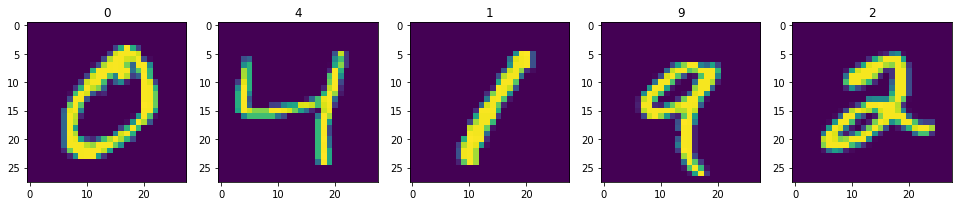

In [42]:
# visualize
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(training_data[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(training_data[i][1])
    plt.imshow(img)

plt.show()

In [43]:
# creating models
# get cpu or gpu for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# define the model
# create a class that inherit from nn.Module
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )
  
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

# create model
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [44]:
# optimize and train model
# loss function and optimizer needed to train the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # backpropagation
    # to adjust the model params
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

# test model performance and to enrsume it is learning
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f'Test error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [45]:
# train
# process over several iterations (epochs)
epochs = 5
for t in range(epochs):
  print(f'Epoch {t + 1}\n----------------------------')
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print('Done!')

Epoch 1
----------------------------
loss: 2.305352 [    0/60000]
loss: 2.292991 [ 6400/60000]
loss: 2.288218 [12800/60000]
loss: 2.293006 [19200/60000]
loss: 2.286736 [25600/60000]
loss: 2.276274 [32000/60000]
loss: 2.264342 [38400/60000]
loss: 2.266627 [44800/60000]
loss: 2.251602 [51200/60000]
loss: 2.247814 [57600/60000]
Test error: 
 Accuracy: 44.9%, Avg loss: 2.250854 

Epoch 2
----------------------------
loss: 2.249734 [    0/60000]
loss: 2.238569 [ 6400/60000]
loss: 2.249748 [12800/60000]
loss: 2.223540 [19200/60000]
loss: 2.234305 [25600/60000]
loss: 2.221308 [32000/60000]
loss: 2.197688 [38400/60000]
loss: 2.217371 [44800/60000]
loss: 2.181337 [51200/60000]
loss: 2.173653 [57600/60000]
Test error: 
 Accuracy: 60.8%, Avg loss: 2.177777 

Epoch 3
----------------------------
loss: 2.172333 [    0/60000]
loss: 2.157689 [ 6400/60000]
loss: 2.189494 [12800/60000]
loss: 2.122445 [19200/60000]
loss: 2.151906 [25600/60000]
loss: 2.132870 [32000/60000]
loss: 2.087706 [38400/60000]
lo

In [46]:
# saving model
torch.save(model.state_dict(), 'model.pth')
print('Saved PyTorch model state to model.pth')

Saved PyTorch model state to model.pth


In [47]:
# load model
model = NeuralNetwork()
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [48]:
# utility
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted digit: 2


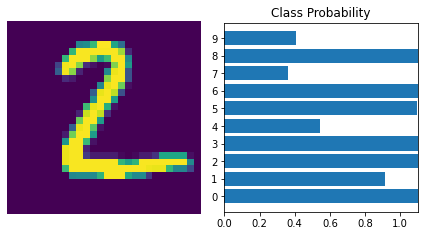

In [49]:
# the model now can be used to make a predictions
images, labels = next(iter(test_dataloader))
img = images[1].view(1, 784)

model.eval()
with torch.no_grad():
  logps = model(img)

ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print(f'Predicted digit: {probab.index(max(probab))}')
view_classify(img.view(1, 28, 28), ps)